# Proyecto Final - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA


El objetivo de este proyecto es generar un modelo de Machine Learning que mejore el desempeño obtenido en el Proyecto 3.

A diferencia del anterior, en este proyecto utilizaré más datos para nutrir el modelo de Árbol de Decisión, como por ejemplo tipo de vehículo, sentido, entre otros. 
El análisis exploratorio de datos se realizará sobre la totalidad de estaciones de peaje, y sobre todas las formas de pago. El punto de partida será muy similar al plateado en el proyecto 3, para tener como punto de partida un dataset familiar y ordenado.

Comprender el comportamiento de las distintas estaciones, las formas de pago que se utilizan, los tipos de vehículos que circulan por las autopistas, es de suma importancia para que la empresa AUSA pueda tomar distintas decisiones, como por ejemplo:
- Inversión en mayor o menor infraestructura para barreras automáticas.
- Inversión en mayor difusión de la alternativa de telepase.
- Dónde destinar mayores fondos a reparaciones, al identificar donde hay mayor cantidad de pasos y de que tipo de vehículos.
- Política de contratación o reubicación de empleados, en caso de que cambie el comportamiento de los usuarios.

La lista mencionada anteriormente no es exhaustiva, solo se trata de mostrar la gran utilidad que el análisis exploratorio de datos y modelos de machine learning con buen desempeño pueden traer a la empresa.

Utilizaré un modelo de regresión lineal como benchmark y luego, según la conclusión planteada en el proyecto anterior, realizaré un modelo de Árbol de Decisión. Luego compararé el RMSEde ambos proyectos. Si bien el benchmark planteado es el mismo que para el Proyecto 3, esta vez se hará sobre todas las estaciones y medios de pago.

### Análisis exploratorio de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import plotly.express as px
import seaborn as sns

In [2]:
#Importo los 3 datasets:

data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

In [3]:
#Uno los 3 datasets:

dataset = pd.concat([data_2019, data_2018, data_2017])
dataset.head()

periodo       fecha  hora_inicio  hora_fin     dia    estacion    sentido  \
0     2019  2019-01-01            0         1  Martes     Alberti     Centro   
1     2019  2019-01-01            0         1  Martes     Alberti     Centro   
2     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
3     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
4     2019  2019-01-01            0         1  Martes  Avellaneda     Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              22  
1       Liviano    TELEPASE               6  
2       Liviano  NO COBRADO              53  
3       Liviano    TELEPASE              18  
4       Liviano    EFECTIVO              16

In [4]:
#Analizo los valores de las distintas columnas

print(dataset['dia'].unique())
print(dataset['estacion'].unique())
print(dataset['sentido'].unique())
print(dataset['tipo_vehiculo'].unique())
print(dataset['forma_pago'].unique())

['Martes' 'Viernes' 'Lunes' 'Miércoles' 'Sábado' 'Jueves' 'Domingo']
['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB' 'Alberdi' 'Dellepiane Centro' 'Dellepiane Liniers']
['Centro' 'Provincia']
['Liviano' 'Pesado']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD' 'TARJETA DISCAPACIDAD' 'MONEDERO' 'Otros']


In [5]:
#A partir de lo observado en la celda anterior, realizo algunas modificaciones a los campos:

#En "estacion"
dataset = dataset.replace({'Dellepiane Centro':'Dellepiane', 'Dellepiane Liniers':'Dellepiane', 'Alberti':'Alberdi'})

#En "forma_pago"
dataset = dataset.replace("T. DISCAPACIDAD","TARJETA DISCAPACIDAD")

print(dataset['forma_pago'].unique())
print(dataset['estacion'].unique())

dataset

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'TARJETA DISCAPACIDAD' 'MONEDERO' 'Otros']
['Alberdi' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']


periodo       fecha  hora_inicio  hora_fin      dia    estacion  \
0           2019  2019-01-01            0         1   Martes     Alberdi   
1           2019  2019-01-01            0         1   Martes     Alberdi   
2           2019  2019-01-01            0         1   Martes     Alberdi   
3           2019  2019-01-01            0         1   Martes     Alberdi   
4           2019  2019-01-01            0         1   Martes  Avellaneda   
...          ...         ...          ...       ...      ...         ...   
1372640     2017  2017-12-31           22        23  Domingo   Sarmiento   
1372641     2017  2017-12-31           22        23  Domingo   Sarmiento   
1372642     2017  2017-12-31           22        23  Domingo   Sarmiento   
1372643     2017  2017-12-31           23         0  Domingo   Sarmiento   
1372644     2017  2017-12-31           23         0  Domingo   Sarmiento   

           sentido tipo_vehiculo  forma_pago  cantidad_pasos  
0           Centro       Liviano  NO COBRADO              22  
1           Centro       Liviano    TELEPASE               6  
2        Provincia       Liviano  NO COBRADO              53  
3        Provincia       Liviano    TELEPASE              18  
4           Centro       Liviano    EFECTIVO              16  
...            ...           ...         ...             ...  
1372640  Provincia       Liviano  NO COBRADO               3  
1372641  Provincia       Liviano    TELEPASE              10  
1372642  Provincia        Pesado    TELEPASE               1  
1372643  Provincia       Liviano  NO COBRADO               1  
1372644  Provincia       Liviano    TELEPASE               4  

[3560706 rows x 10 columns]

In [6]:
#Pasó la columna fecha a formato datetime, y le uno la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

In [7]:
#Remuevo las columnas que no utilizaré y le cambio el nombre a la nueva columna de fecha
dataset.drop(columns = ['hora_inicio' , 'hora_fin' , 'fecha'], inplace = True)
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

periodo     dia    estacion    sentido tipo_vehiculo  forma_pago  \
0     2019  Martes     Alberdi     Centro       Liviano  NO COBRADO   
1     2019  Martes     Alberdi     Centro       Liviano    TELEPASE   
2     2019  Martes     Alberdi  Provincia       Liviano  NO COBRADO   
3     2019  Martes     Alberdi  Provincia       Liviano    TELEPASE   
4     2019  Martes  Avellaneda     Centro       Liviano    EFECTIVO   

   cantidad_pasos               fecha  
0              22 2019-01-01 01:00:00  
1               6 2019-01-01 01:00:00  
2              53 2019-01-01 01:00:00  
3              18 2019-01-01 01:00:00  
4              16 2019-01-01 01:00:00

In [8]:
#Reordeno el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

periodo      dia    estacion    sentido tipo_vehiculo  forma_pago  \
0           2017  Domingo  Dellepiane     Centro       Liviano  NO COBRADO   
1           2017  Domingo       Illia  Provincia       Liviano    EFECTIVO   
2           2017  Domingo       Illia  Provincia       Liviano  NO COBRADO   
3           2017  Domingo  Dellepiane  Provincia       Liviano  INFRACCION   
4           2017  Domingo  Avellaneda     Centro       Liviano  NO COBRADO   
...          ...      ...         ...        ...           ...         ...   
3560701     2019   Martes  Dellepiane  Provincia        Pesado    TELEPASE   
3560702     2019   Martes  Dellepiane  Provincia        Pesado  NO COBRADO   
3560703     2019   Martes  Dellepiane  Provincia        Pesado      EXENTO   
3560704     2019   Martes  Dellepiane  Provincia       Liviano    TELEPASE   
3560705     2019   Martes  Avellaneda     Centro       Liviano      EXENTO   

         cantidad_pasos               fecha  
0                     6 2017-01-01 00:00:00  
1                     9 2017-01-01 00:00:00  
2                     3 2017-01-01 00:00:00  
3                     3 2017-01-01 00:00:00  
4                    36 2017-01-01 00:00:00  
...                 ...                 ...  
3560701              13 2019-12-31 23:00:00  
3560702               1 2019-12-31 23:00:00  
3560703               2 2019-12-31 23:00:00  
3560704             150 2019-12-31 23:00:00  
3560705               3 2019-12-31 23:00:00  

[3560706 rows x 8 columns]

In [9]:
# Exporto como csv el dataset para tenerlo como punto de partida
dataset.to_csv('dataset_proyecto_final.csv')

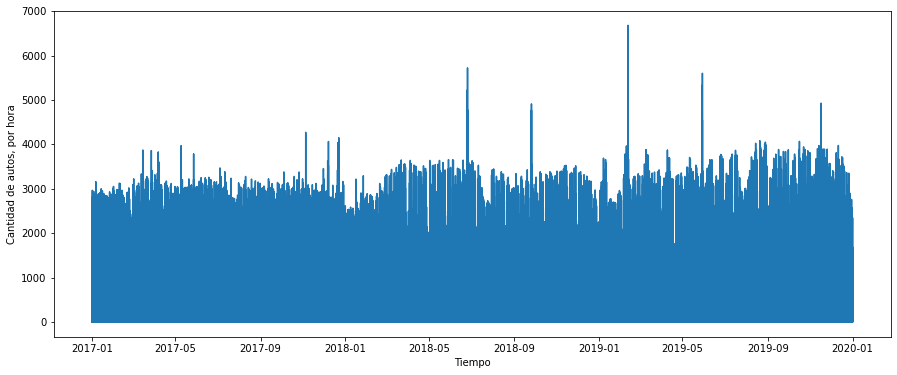

In [10]:
#Grafico nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [11]:
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 2)


periodo  cantidad_pasos
fecha                              
2017-01-01  5349084          220443
2017-01-02  7823943          337393
2017-01-03  7793688          342942
2017-01-04  7890504          355057
2017-01-05  7979252          367739

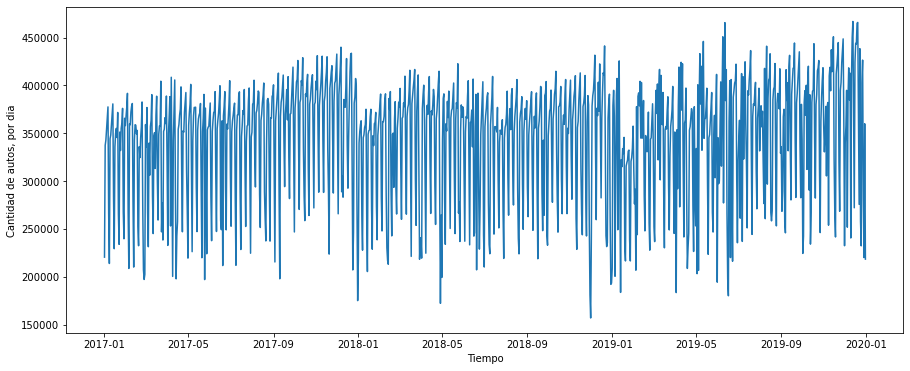

In [12]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

De este primer gráfico no se puede obtener mucha información, por lo que seguiré trabajando en el dataset para poder obtener mayor información.
Para eso, primero realizaré un resampleo semanal del dataset.

In [13]:
semanal = dataset.resample('W', on = 'fecha').sum()
print(diario.shape)
semanal.head()

(1095, 2)


periodo  cantidad_pasos
fecha                               
2017-01-01   5349084          220443
2017-01-08  52986590         2260596
2017-01-15  53160052         2314268
2017-01-22  53769186         2257919
2017-01-29  54039464         2282364

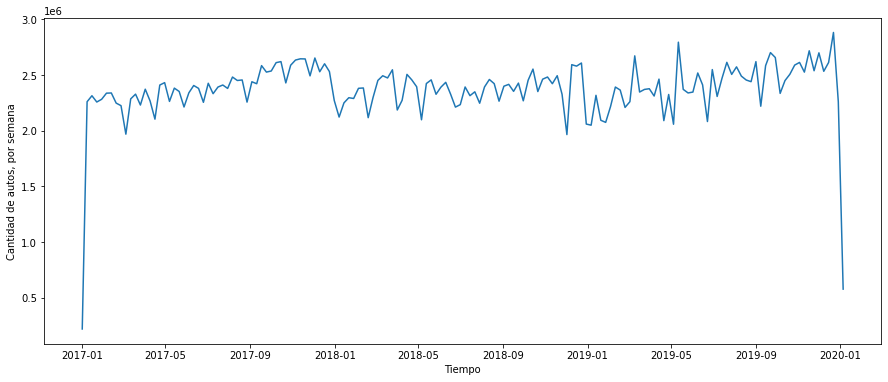

In [14]:
plt.figure(figsize = (15,6))
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.show()

Analizaré un poco más el dataset resampleado en forma semanal, ya que el gráfico presenta valores atípicos:

In [15]:
semanal.head()

periodo  cantidad_pasos
fecha                               
2017-01-01   5349084          220443
2017-01-08  52986590         2260596
2017-01-15  53160052         2314268
2017-01-22  53769186         2257919
2017-01-29  54039464         2282364

In [16]:
semanal.tail()

periodo  cantidad_pasos
fecha                               
2019-12-08  31379298         2533762
2019-12-15  33071220         2613146
2019-12-22  33406374         2882347
2019-12-29  31550913         2259814
2020-01-05   8932056          578292

De observar head y tail, podemos observar que la primera y la última semana tienen valores atípicos, lo que se debe a que no son semanas completas, por lo que las eliminaré y realizaré el gráfico nuevamente:

In [17]:
semanal.drop(semanal.index[0], inplace = True)                     
semanal.drop(semanal.index[-1], inplace = True)

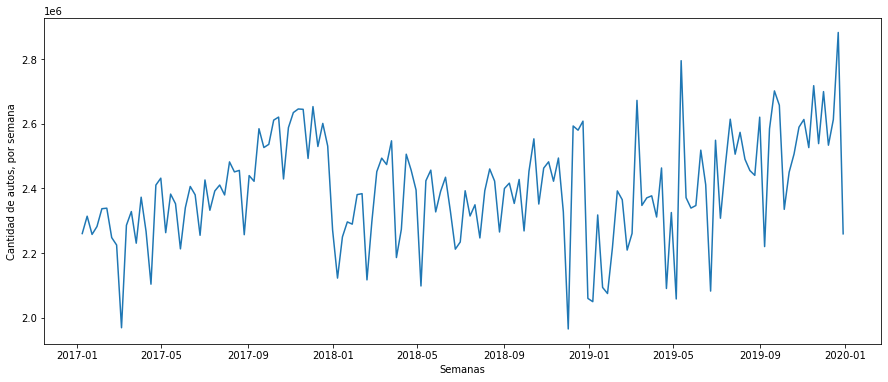

In [18]:
plt.figure(figsize = (15,6))
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.xlabel('Semanas')
plt.ylabel('Cantidad de autos, por semana')
plt.show()

A partir de este gráfico podemos observar una tendencia creciente desde 2017 a 2019.
También se puede ver como 2017 y 2019 fueron años con mucha variabilidad mientras el 2018 fue un año más estable.

A partir de la información con la que contamos en el dataset, realizaré distintos análisis en cuanto al tipo de vehículo, formasde pago, estaciones de peaje, etc.

In [19]:
#Importo plotly para poder utilizarlo de ahora en adelante
import plotly.express as px

In [20]:
dataset_day = dataset.groupby(["periodo","dia"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")

In [21]:
fig = px.line(dataset_day, x='dia', y='cantidad_pasos', color='periodo')
fig.show()

Podemos observar como el comportamiento del tráfico analizado por día es esperable: tiende a aumentar de lunes a viernes dentro de la semana, para declinar de forma pronunciada los días sabado y domingo.
Por la forma en que están nombrados los días no se permite ver en forma ordenada, por lo que realizaré algunos cambios al dataset para poder apreciarlo mejor.

In [22]:
dataset["dia_num"] = dataset["dia"]
dataset["dia_num"].replace({"Lunes": "1", "Martes": "2", "Miércoles": "3", 
                           "Jueves": "4", "Viernes": "5",  
                           "Sábado": "6", "Domingo": "7" }, inplace=True)

dataset.head()

periodo      dia    estacion    sentido tipo_vehiculo  forma_pago  \
0     2017  Domingo  Dellepiane     Centro       Liviano  NO COBRADO   
1     2017  Domingo       Illia  Provincia       Liviano    EFECTIVO   
2     2017  Domingo       Illia  Provincia       Liviano  NO COBRADO   
3     2017  Domingo  Dellepiane  Provincia       Liviano  INFRACCION   
4     2017  Domingo  Avellaneda     Centro       Liviano  NO COBRADO   

   cantidad_pasos      fecha dia_num  
0               6 2017-01-01       7  
1               9 2017-01-01       7  
2               3 2017-01-01       7  
3               3 2017-01-01       7  
4              36 2017-01-01       7

In [23]:
dataset_day = dataset.groupby(["periodo","dia_num"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")
fig = px.line(dataset_day, x='dia_num', y='cantidad_pasos', color='periodo')
fig.show()

Si bien la información es la misma del gráfico anterior, en este podemos apreciarla información en orden cronológico, lo cual permite una mejor interpretación visual. También podemos osbervar que los años 2017 y 2018 tienen un compartamiento más similar entre ellos, mientras que 2019 difiere levemente.A simple vista no podemos deducir que un año haya mayor tráfico que en otro de froma absoluta, ya que las curvas para los 3 años se entrecruzan. Si podemos ver que a lo largo de toda la semana la cantidad de autos circulando durante 2018 fue menor a 2017. El 2019 presenta días por encima y días por debajo de las curvas correspondientes a los otros 2 años. 

A continuación trabajaré el dataset y los gráfico para intentar observar de forma más precisa la cantidad de autos en circulación para los 3 años bajo análisis.

In [24]:
dataset_day = dataset.groupby(["periodo"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")
fig = px.bar(dataset_day, x='periodo', y='cantidad_pasos')
fig.show()

Si bien puede observarse que el año con más pasos es el año 2019, seguido por 2017 y el de menor cantidad el 2018, son cantidades muy similares.
Siguiendo los descubrimiento realizados en el Proyecto anterior, sabemos que hubo acontecimientos de gran impacto para la circulación de vehículos:

- 06/04/2017: Jueves, Paro general
- 25/06/2018: Lunes, Paro nacional
- 25/09/2018: Martes, Paro nacional
- 30/11/2018: Viernes, Cumbre del G20 en Buenos Aires
- 01/12/2018: Sábado, día posterior a Cumbre del G20
- 29/05/2019: Miércoles, Paro nacional

De estos eventos, la mayoría ocurrieron en 2018, y el de mayor magnitud fue la Cumbre del G20, lo que explicaría en parte que este año presente menor cantidad de pasos.

A continuación presento un gráfico diario, para poder visualizar la situación mencionada:

In [25]:
diario = dataset.resample('D', on = 'fecha').sum()

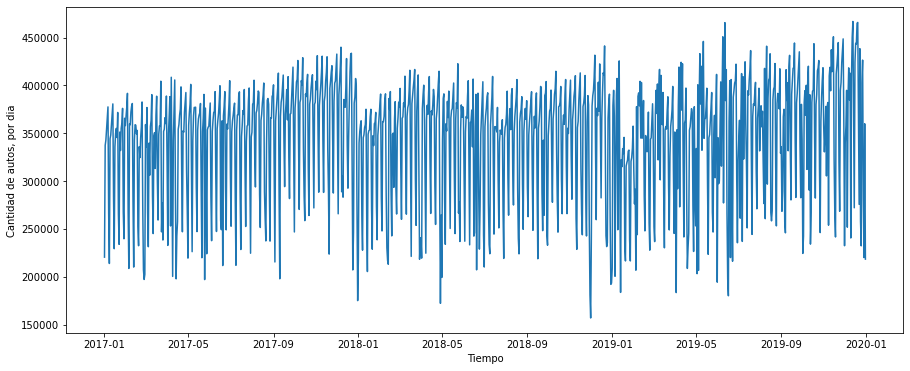

In [26]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Ahora proseguiré con un análisis por estación, viendo que estaciones son las más concurridas para pasar después a identificar las formas de pago más utilizadas en cada una.
El objetivo es ver el comportamiento de las formas de pago, para poder identificar en que estaciones AUSA debería hacer incapie en el fomento del telepase.

In [27]:
dataset_estacion = dataset.groupby(["estacion"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")
fig = px.bar(dataset_estacion, x='estacion', y='cantidad_pasos')
fig.show()

In [28]:
dataset_pago = dataset.groupby(["estacion" , "forma_pago"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")
dataset_pago.head()

estacion            forma_pago  cantidad_pasos
0  Alberdi              EFECTIVO         9386561
1  Alberdi                EXENTO          358321
2  Alberdi            INFRACCION           81481
3  Alberdi            NO COBRADO          673112
4  Alberdi  TARJETA DISCAPACIDAD          221031

In [29]:
fig = px.bar(dataset_pago, x='estacion', y='cantidad_pasos', color='forma_pago')
fig.show()

Podemos observar que en las estaciones de peaje más transitadas, la cantidad de pagos en efectivo es mayor a la cantidad de pagos con telepase, por lo que se debería seguir trabajando en el fomento de este último.
Por otro lado, en las estaciones más pequeñas la situación es diferente.
En retiro podemos osbervar que los pagos con telepase superan a los hechos en efectivo.
En PBD, Salguero y Sarmiento, podemos ver que también predominan los pagos con telepase y que AUSA debería incrementar esfuerzos en la cantidad de pases no cobrados.
A continuación analizaré la evolución de las formas de pago, para entender como avanzó AUSA a lo largo de los años y si sus esfuerzos en promocionar el telepase están dando frutos.

In [30]:
dataset_periodo_pago = dataset.groupby(["periodo" , "forma_pago"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")
dataset_periodo_pago.head()

periodo  forma_pago  cantidad_pasos
0     2017    EFECTIVO        69502938
1     2017      EXENTO         1677497
2     2017  INFRACCION          629550
3     2017    MONEDERO              16
4     2017  NO COBRADO         4845670

In [31]:
fig = px.bar(dataset_periodo_pago, x='forma_pago', y='cantidad_pasos', color="periodo")
fig.show()

Se puede apreciar claramente que la forma de pago "efectivo" ha disminuido a lo largo de los 3 años, mientras que "telepase" se ha visto incrementada y estaría marcando una tendencia. Esto nos permitiría concluir que si bien AUSA debe ahondar en esfuerzos para que los usuarios migren al telepase, su trabajo en los últimos años está dando resultado.

A continuación realizaré un análisis de los tipos de vehículos y los sentidos en que se mueven, para obtener más información a cerca de los usuarios, lo que permitiría a AUSA comprender mejor en quiénes ahondar sus esfuerzos para promover el telepase.

In [32]:
dataset_tipo = dataset.groupby(["tipo_vehiculo", "estacion"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")
dataset_tipo.head()

tipo_vehiculo    estacion  cantidad_pasos
0       Liviano     Alberdi        16542999
1       Liviano  Avellaneda       133116697
2       Liviano  Dellepiane        80468735
3       Liviano       Illia        98219285
4       Liviano         PDB          890931

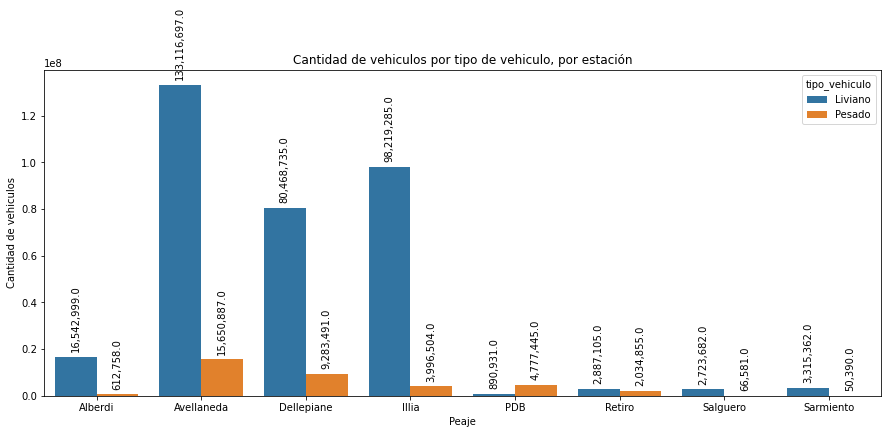

In [33]:
plt.figure(figsize = (15,6))

barplt = sns.barplot(data = dataset_tipo, x = "estacion", y = "cantidad_pasos", hue = "tipo_vehiculo")
plt.xlabel("Peaje")
plt.ylabel("Cantidad de vehiculos")
plt.title("Cantidad de vehiculos por tipo de vehiculo, por estación")

coment=barplt.patches
for coment in coment :
    y_value = coment.get_height()
    x_value = coment.get_x() + coment.get_width()/2
    space = 5
    va = 'bottom'
    label = "{:,}".format(y_value)
    
    plt.annotate(
     label,
     (x_value, y_value),
     xytext=(0, space),
     textcoords="offset points",
     rotation = 'vertical',
     ha='center',
     va=va)
plt.show()

Podemos observar, como es de esperarse, que los usuarios con vehiculos livianos son el principal target de AUSA en la mayoría de sus estaciones, pero por ejemplo en "PBD" deberían enfocarse más en vehiculos pesados, ya que es significativamente mayor su paso por dicha estación.

In [34]:
dataset_sentido = dataset.groupby(["estacion", "sentido"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")
dataset_sentido.head()

estacion    sentido  cantidad_pasos
0     Alberdi     Centro         6924688
1     Alberdi  Provincia        10231069
2  Avellaneda     Centro        73792441
3  Avellaneda  Provincia        74975143
4  Dellepiane     Centro        46295302

In [35]:
fig = px.bar(dataset_sentido, x='sentido', y='cantidad_pasos', color="estacion")
fig.show()

Podemos osbervar como, con excepción de algunas estaciones, en su gran mayoría presentan un comportamiento similar en ambos sentidos.
A continuación incorparé el dato de las horas, para poder analizar los momentos picos. Dicha información puede ser útil para decidir distintas medidas que tengan como target promocionar el telepase.

In [36]:
dataset["hora"] = dataset["fecha"].dt.hour
dataset.head()

periodo      dia    estacion    sentido tipo_vehiculo  forma_pago  \
0     2017  Domingo  Dellepiane     Centro       Liviano  NO COBRADO   
1     2017  Domingo       Illia  Provincia       Liviano    EFECTIVO   
2     2017  Domingo       Illia  Provincia       Liviano  NO COBRADO   
3     2017  Domingo  Dellepiane  Provincia       Liviano  INFRACCION   
4     2017  Domingo  Avellaneda     Centro       Liviano  NO COBRADO   

   cantidad_pasos      fecha dia_num  hora  
0               6 2017-01-01       7     0  
1               9 2017-01-01       7     0  
2               3 2017-01-01       7     0  
3               3 2017-01-01       7     0  
4              36 2017-01-01       7     0

In [37]:
dataset_hora = dataset.groupby(["hora","sentido"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")

In [38]:
fig = px.bar(dataset_hora, x='hora', y='cantidad_pasos', color="sentido")
fig.show()

A partir del gráfico se puede observar claramente el comportamiento del tráfico. Si bien de 09.00 a 19.00 ambos sentidos presentan un comportamiento similar, se puede osbervar como el sentido "Centro" aumenta a la mañana para disminuir hacia la tarde, y el sentido "Provincia" tiene el comportamiento opuesto. Esto le brinda a la empresa más información respecto de como elegir el target en franjas horarias, y en uno u otro sentido, para distintas campañas de promoción de telepase.

### Modelos de Machine Learning

Siguiendo las conclusiones del proyecto anterior, en esta entrega final plantearé un modelo de regresión lineal como benchmark (al igual que en el proyecto 3) para luego comparar con un modelo de Árboles de decisión, incorporando también la optimización de hiperparámetros. 

###### Modelo de Regresión Lineal:

In [39]:
diario['fecha_numeros'] = diario.index.map(datetime.datetime.toordinal)

split_date = '2019-09-30'

train = diario.loc[diario.index <= split_date].copy()
test  = diario.loc[diario.index >  split_date].copy()

In [40]:
from sklearn.linear_model import LinearRegression
benchmark_rl = LinearRegression()
benchmark_rl.fit(train.fecha_numeros.values.reshape(-1, 1), train.cantidad_pasos)

LinearRegression()

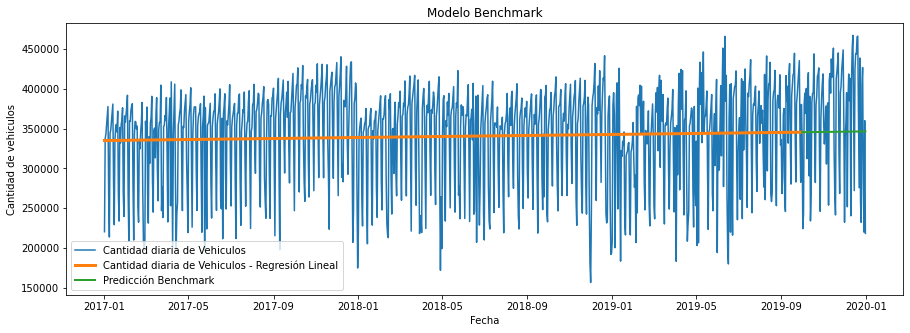

In [41]:
plt.figure(figsize = (15,5))
plt.plot(diario.index, diario.cantidad_pasos, label = 'Cantidad diaria de Vehiculos')
plt.plot(train.index, benchmark_rl.predict(train.fecha_numeros.values.reshape(-1, 1)), lw = 3, label = 'Cantidad diaria de Vehiculos - Regresión Lineal')
plt.plot(test.index,  benchmark_rl.predict(test.fecha_numeros.values.reshape(-1, 1)),  lw = 2, label = 'Predicción Benchmark')

plt.xlabel('Fecha')
plt.ylabel('Cantidad de vehiculos')
plt.legend()
plt.title("Modelo Benchmark")
plt.show()

In [42]:
from sklearn.metrics import mean_squared_error
benchmark_rmse = np.sqrt(mean_squared_error(test.cantidad_pasos, benchmark_rl.predict(test.fecha_numeros.values.reshape(-1, 1))))

print('RMSE modelo Benchmark: %.1f' % benchmark_rmse)


RMSE modelo Benchmark: 72563.1


In [43]:
from sklearn.metrics import mean_absolute_error
benchmark_mae = np.sqrt(mean_absolute_error(test.cantidad_pasos, benchmark_rl.predict(test.fecha_numeros.values.reshape(-1, 1))))
print('MAE: %.3f' % benchmark_mae)

MAE: 254.004


###### Modelo de Árboles de decisión:

In [44]:
from sklearn.tree import DecisionTreeRegressor

In [45]:
dataset['fecha_numeros'] = dataset.fecha.map(datetime.datetime.toordinal)
dataset = dataset.drop(columns = ["fecha"])
dataset = pd.get_dummies(dataset)
dataset.head()

periodo  cantidad_pasos  hora  fecha_numeros  dia_Domingo  dia_Jueves  \
0     2017               6     0         736330            1           0   
1     2017               9     0         736330            1           0   
2     2017               3     0         736330            1           0   
3     2017               3     0         736330            1           0   
4     2017              36     0         736330            1           0   

   dia_Lunes  dia_Martes  dia_Miércoles  dia_Sábado  ...  forma_pago_Otros  \
0          0           0              0           0  ...                 0   
1          0           0              0           0  ...                 0   
2          0           0              0           0  ...                 0   
3          0           0              0           0  ...                 0   
4          0           0              0           0  ...                 0   

   forma_pago_TARJETA DISCAPACIDAD  forma_pago_TELEPASE  dia_num_1  dia_num_2  \
0                                0                    0          0          0   
1                                0                    0          0          0   
2                                0                    0          0          0   
3                                0                    0          0          0   
4                                0                    0          0          0   

   dia_num_3  dia_num_4  dia_num_5  dia_num_6  dia_num_7  
0          0          0          0          0          1  
1          0          0          0          0          1  
2          0          0          0          0          1  
3          0          0          0          0          1  
4          0          0          0          0          1  

[5 rows x 38 columns]

In [46]:
split_date = datetime.date(2019, 9, 30)
split_date = split_date.toordinal()
train = dataset.loc[dataset.fecha_numeros <= split_date].copy()
test  = dataset.loc[dataset.fecha_numeros >  split_date].copy()

In [47]:
X_train = train.drop(columns = ["cantidad_pasos"])
X_test  = test.drop(columns = ["cantidad_pasos"])

y_train = train.cantidad_pasos
y_test  = test.cantidad_pasos

In [48]:
model_regtree = DecisionTreeRegressor()
model_regtree.fit(X_train, y_train)

y_train_pred = model_regtree.predict(X_train)
y_test_pred  = model_regtree.predict(X_test)

Calculo y gráfico el RMSE obtenido:

RMSE Train modelo Árbol de Decisión: 160.6
RMSE Test modelo Árbol de Decisión: 140.2


C:\Users\fjfab\miniconda3\envs\datasciencetime\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\fjfab\miniconda3\envs\datasciencetime\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



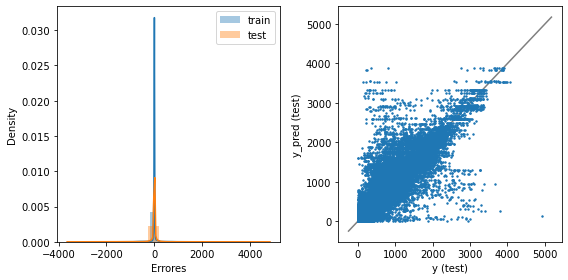

In [49]:
from sklearn.metrics import mean_squared_error

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test  = np.sqrt(mean_squared_error(y_test, y_test_pred))

print('RMSE Train modelo Árbol de Decisión: %.1f' % rmse_train)
print('RMSE Test modelo Árbol de Decisión: %.1f' % rmse_test)


plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred , bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred , bins = 20, label = 'test')
plt.xlabel('Errores')
plt.legend()

ax = plt.subplot(1,2,2)
ax.scatter(y_test , y_test_pred , s =2)
    
lims = [
np.min([ax.get_xlim() , ax.get_ylim()]),  
np.max([ax.get_xlim() , ax.get_ylim()]),  
]
    
ax.plot(lims, lims, 'k-', alpha=0.5, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
    
plt.tight_layout()
plt.show()
plt.show()

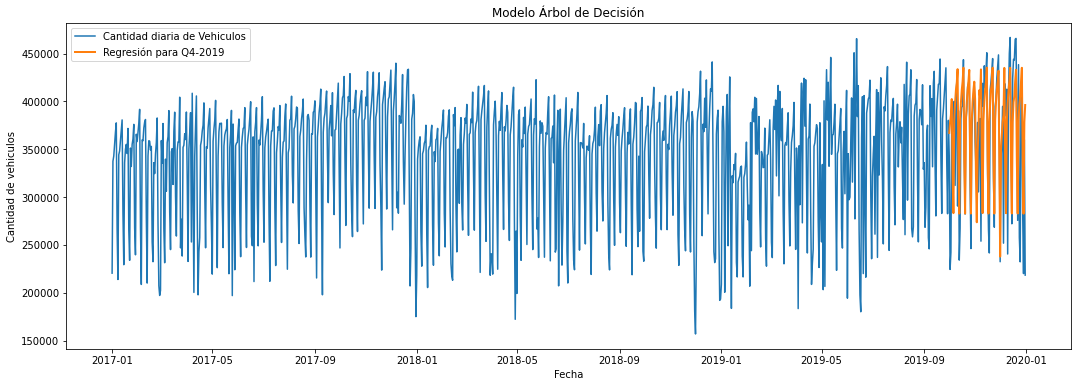

In [50]:
plt.figure(figsize = (18,6))

test['fecha'] = test.fecha_numeros.map(datetime.datetime.fromordinal)
test['prediccion'] = y_test_pred

test = test.groupby(["fecha"])[("prediccion")].sum().reset_index(name="prediccion")

test.set_index('fecha', inplace = True)

plt.plot(diario.index, diario.cantidad_pasos, label = 'Cantidad diaria de Vehiculos')
plt.plot(test.index,  test.prediccion,  lw = 2, label = 'Regresión para Q4-2019')

plt.xlabel('Fecha')
plt.ylabel('Cantidad de vehiculos')
plt.legend()
plt.title("Modelo Árbol de Decisión")
plt.show()

A partir del modelos de Árboles de decisión se puede ver una significativa mejora en el desempeño del modelo. Esto puede explicarse a partir de que en este modelo podemos introducir variables categóricas, lo cual brinda información que es de suma utilidad.
Más allá del buen desempeño obtenido, utilizaré Random Search para intentar obtener un mejor resultado a partir de la optimización de hiperparámetros.

C:\Users\fjfab\miniconda3\envs\datasciencetime\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



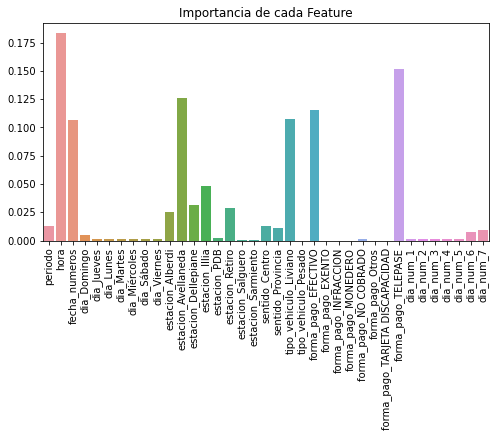

In [51]:
forest_important_variables = model_regtree.feature_importances_
columns = X_train.columns
plt.figure(figsize = (8,4))
sns.barplot(columns, forest_important_variables)
plt.title('Importancia de cada Feature')
plt.xticks(rotation = 90)
plt.show()

A partir del análisis de importancia de las features, puedo proceder a eliminar algunas variables:

In [52]:
dataset  = dataset.drop(columns = ["forma_pago_EXENTO" , "forma_pago_MONEDERO" , "forma_pago_INFRACCION" , "forma_pago_Otros"])
dataset  = dataset.drop(columns = ["dia_Domingo" , "dia_Jueves" , "dia_Lunes" , "dia_Martes" , "dia_Miércoles" , "dia_Sábado" , "dia_Viernes"])


In [53]:
dataset.head()

periodo  cantidad_pasos  hora  fecha_numeros  estacion_Alberdi  \
0     2017               6     0         736330                 0   
1     2017               9     0         736330                 0   
2     2017               3     0         736330                 0   
3     2017               3     0         736330                 0   
4     2017              36     0         736330                 0   

   estacion_Avellaneda  estacion_Dellepiane  estacion_Illia  estacion_PDB  \
0                    0                    1               0             0   
1                    0                    0               1             0   
2                    0                    0               1             0   
3                    0                    1               0             0   
4                    1                    0               0             0   

   estacion_Retiro  ...  forma_pago_NO COBRADO  \
0                0  ...                      1   
1                0  ...                      0   
2                0  ...                      1   
3                0  ...                      0   
4                0  ...                      1   

   forma_pago_TARJETA DISCAPACIDAD  forma_pago_TELEPASE  dia_num_1  dia_num_2  \
0                                0                    0          0          0   
1                                0                    0          0          0   
2                                0                    0          0          0   
3                                0                    0          0          0   
4                                0                    0          0          0   

   dia_num_3  dia_num_4  dia_num_5  dia_num_6  dia_num_7  
0          0          0          0          0          1  
1          0          0          0          0          1  
2          0          0          0          0          1  
3          0          0          0          0          1  
4          0          0          0          0          1  

[5 rows x 27 columns]

###### Random Search:


In [54]:
from pprint import pprint
print('Parameters currently in use:\n')
pprint(model_regtree.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}


In [55]:
params = {'min_samples_split' : np.arange(2,5),
              'min_samples_leaf'  : np.arange(1,5)}

In [56]:
from sklearn.model_selection import RandomizedSearchCV
model = RandomizedSearchCV(model_regtree, params, cv=5)
model.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(),
                   param_distributions={'min_samples_leaf': array([1, 2, 3, 4]),
                                        'min_samples_split': array([2, 3, 4])})

In [57]:
print("Mejores parametros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

Mejores parametros: {'min_samples_split': 2, 'min_samples_leaf': 4}
Mejor Score: 0.5520570961694341



In [60]:
from sklearn.tree import DecisionTreeRegressor

model_regtree2 = DecisionTreeRegressor(min_samples_leaf = 4, min_samples_split = 2)
model_regtree2.fit(X_train, y_train)

y_train_pred = model_regtree2.predict(X_train)
y_test_pred  = model_regtree2.predict(X_test)

RMSE Train modelo Árbol de Decisión: 168.0
RMSE Test modelo Árbol de Decisión: 136.4


C:\Users\fjfab\miniconda3\envs\datasciencetime\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\fjfab\miniconda3\envs\datasciencetime\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



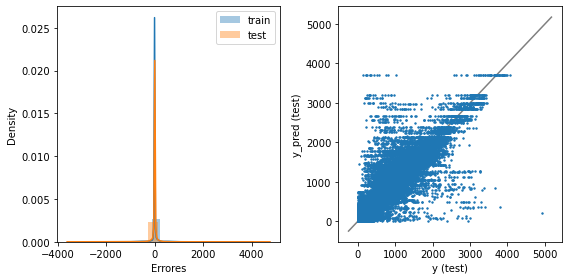

In [61]:
from sklearn.metrics import mean_squared_error

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test  = np.sqrt(mean_squared_error(y_test, y_test_pred))

print('RMSE Train modelo Árbol de Decisión: %.1f' % rmse_train)
print('RMSE Test modelo Árbol de Decisión: %.1f' % rmse_test)


plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred , bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred , bins = 20, label = 'test')
plt.xlabel('Errores')
plt.legend()

ax = plt.subplot(1,2,2)
ax.scatter(y_test , y_test_pred , s =2)
    
lims = [
np.min([ax.get_xlim() , ax.get_ylim()]),  
np.max([ax.get_xlim() , ax.get_ylim()]),  
]
    
ax.plot(lims, lims, 'k-', alpha=0.5, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
    
plt.tight_layout()
plt.show()
plt.show()

Podemos osbervar que después de la optimización de hiperparámetros obtuvimos un mejor desempeño en train, pero peor en test.
De todos modos, se pueden ver resultados muy similares, por lo que considero que el costo que tiene realizar un RandomSearch no justifica la mejora en el desempeño obtenido. Debido al costo computacional no intentaré una nueva optimización con GridSearch.

### Conclusiones

Comparando este Proyecto Final con el Proyecto 03, creo que se ha logrado una mejora significativa en el análisis exploratorio de datos, incluyendo más variables y más análisis de las mismas.
Con respecto a los modelos de Machine Learning ha habido una mejora siginificativa tanto si comparamos el Modelo de Árboles de Decisión como si comparamos con el modelo Prophet desarrollado en el Proyecto 03. Los resultados obtenidos nos muestran la importancia que adquieren los datos cualitativos (observar gráfico de "feature_importance") a la hora de realizar una predicción.
Considero que el avance logrado entre el Proyecto 03 y el Final es satisfactoria, ya que permite una predicción del tráfico con un error tanto en "train" como en "test" muy 